<a href="https://colab.research.google.com/github/lanzetti1/Univesp/blob/main/Aula_20_Pr%C3%A1tica_com_Deep_Learning_para_Classifica%C3%A7%C3%A3o_de_Imagens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COM530 - Visão Computacional

## Semana 7 - Reconhecimento de objetos
## Videoaula 20 - Prática com Deep Learning para Classificação de Imagens

Nesta aula, vamos construir e utilizar a rede convolucional para classificar imagens como Cães ou Gatos. Serão seguidos os seguintes passos:

- Importando os pacotes necessários
- Carregando e explorando os dados
- Construindo uma pequena Convnet
- Treinando a rede
- Avaliando os resultados

Observações: 
- Ativar a GPU (Menu [Runtime], opção [Change runtime type])
- Sem GPU, a execução deste caderno pode levar mais de 40 minutos.


#Importando os pacotes

In [ ]:
import os
import zipfile
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Carregando e explorando os dados

Vamos começar fazendo o download dos dados, um arquivo .zip com 2000 imagens de cães e gatos, no formato JPG, e extraindo-os localmente em `/tmp`.

**NOTA:** Essas 2000 imagens foram extraídas do conjunto de dados ["Dogs vs. Cats"](https://www.kaggle.com/c/dogs-vs-cats/data) disponível no Kaggle, que contém 25.0000 imagens. Vamos utilizar uma amostra do conjunto completo para reduzir o tempo de execução para reduzir o tempo de treinamento.

In [ ]:
!wget --no-check-certificate \
   https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip -O \
   /tmp/cats_and_dogs_filtered.zip

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2023-04-27 14:04:17--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.99.128, 74.125.20.128, 108.177.98.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.99.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   166MB/s    in 0.4s    

2023-04-27 14:04:18 (166 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



O conteúdo do arquivo .zip é descompactado no diretório base `/tmp/cats_and_dogs_filtered`, contendo os subdiretórios `train` e `validation` para treinamento e validação, respectivamente, os quais contêm subdiretórios `cats` (gatos) e `dogs` (cães). Vamos definir esses diretórios:

In [ ]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Diretório com as imagens de gatos para treinamento
train_cats_dir = os.path.join(train_dir, 'cats')

# Diretório com as imagens de cães para treinamento
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Diretório com as imagens de gatos para validação
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Diretório com as imagens de cães para validação
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

Agora, vamos dar uma olhada nos nomes os arquivos das imagens de cães e gatos para treino. O mesmo padrão é utilizado para as imagens para validação:

In [ ]:
train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:10])

train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print(train_dog_fnames[:10])

['cat.559.jpg', 'cat.480.jpg', 'cat.535.jpg', 'cat.262.jpg', 'cat.377.jpg', 'cat.307.jpg', 'cat.787.jpg', 'cat.373.jpg', 'cat.637.jpg', 'cat.740.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']


Vamos verificar o número total de imagens de cães e gatos para treino e validação:

In [ ]:
print('Total de imagens de gatos para treino:', len(os.listdir(train_cats_dir)))
print('Total de imagens de cachorros para treino:', len(os.listdir(train_dogs_dir)))
print('Total de imagens de gatos para validação:', len(os.listdir(validation_cats_dir)))
print('Total de imagens de cachorros para validação:', len(os.listdir(validation_dogs_dir)))

Total de imagens de gatos para treino: 1000
Total de imagens de cachorros para treino: 1000
Total de imagens de gatos para validação: 500
Total de imagens de cachorros para validação: 500


Tanto para cães como para gatos, temos 1000 imagens para treino e 500 para teste. Importante destacar que temos um conjunto de dados bem balanceado.

Vamos dar uma olhada em algumas dessas imagens para entender o conjunto de dados. Primeiro, configuramos os parâmetros do *matplot*:

In [ ]:
# Parâmetors para o gráfico; as imagens serão vizualizadas em formato 4x4
nrows = 4
ncols = 4

# Índice para iterar sobre as imagens
pic_index = 0

Vamos visualizar um lote com 8 gatos e 8 cães. Podemos reexecutar esta célula para visualizar o próximo lote:

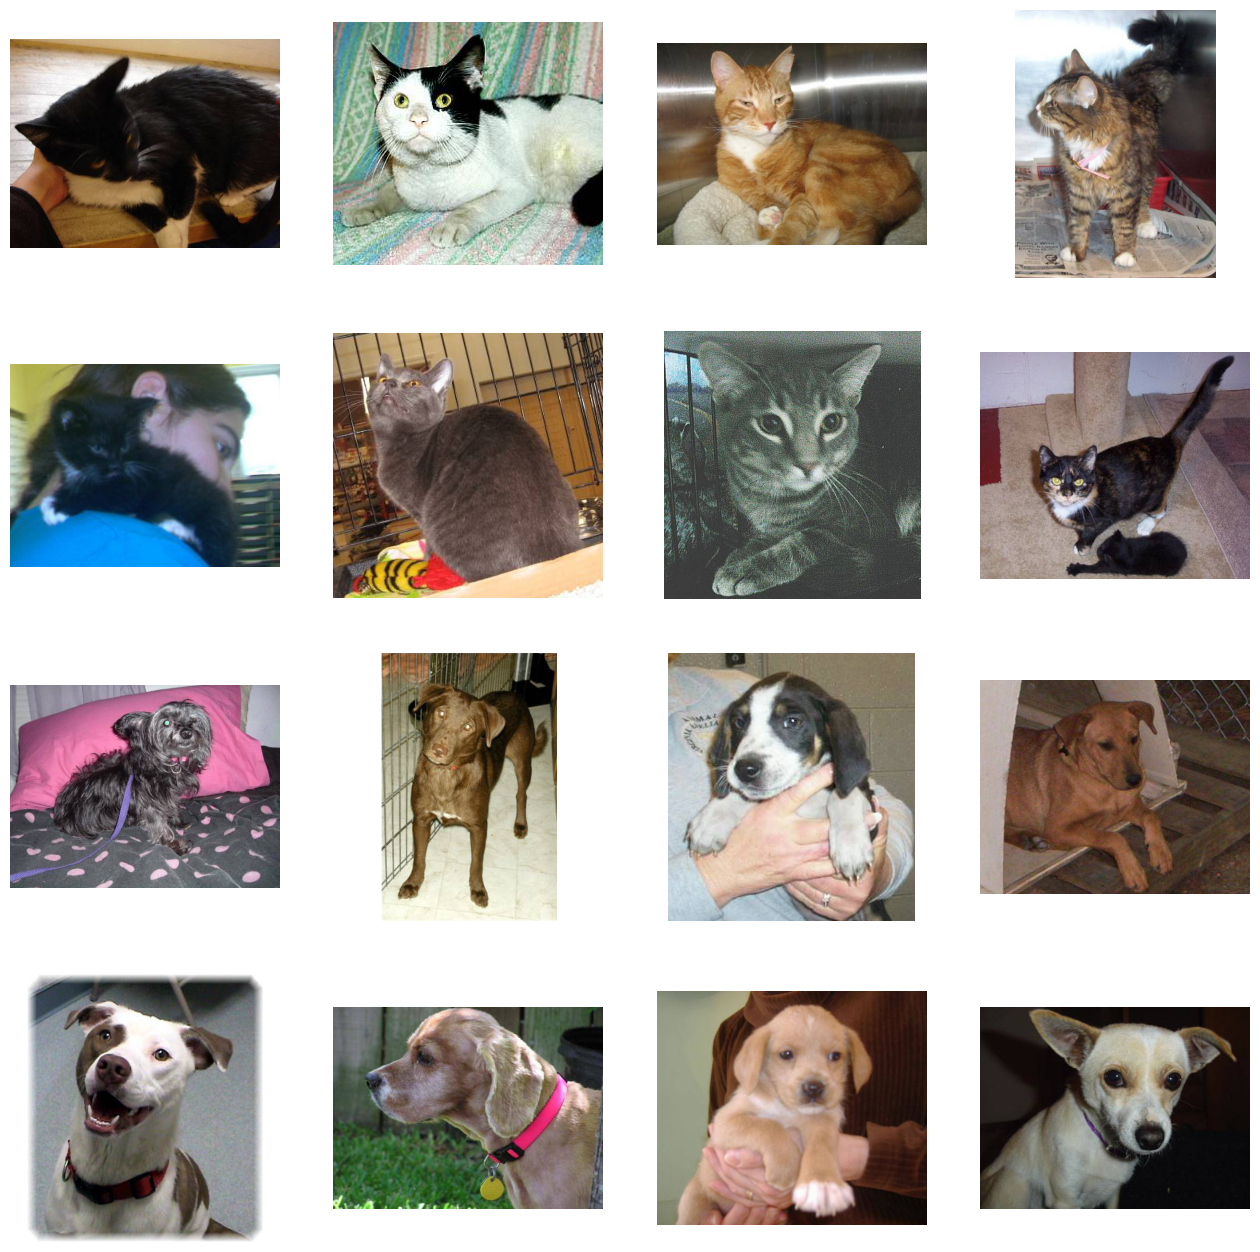

In [ ]:
# Configurar o matplotlib fig, e dimensioná-lo para caber em fotos 4x4
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Configurar o subplot; índices do subplot começam em 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Não mostrar os eixos (ou linhas da grade)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


# Construindo uma pequena Convnet

As imagens a serem utilizadas como entrada da rede convnet são imagens coloridas 150x150. Na próxima seção, todas as imagens serão redimensionadas para 150x150 antes de alimentá-las na rede neural).

Vamos codificar a arquitetura. Vamos empilhar 3 módulos de {convolução + relu + maxpooling}. Nossas convoluções operam em janelas 3x3 e nossas camadas maxpooling operam em janelas 2x2. Nossa primeira convolução extrai 16 filtros, a seguinte extrai 32 filtros e a última extrai 64 filtros.

**NOTA**: Esta é uma configuração amplamente utilizada e conhecida por funcionar bem para a classificação de imagens. Além disso, como temos relativamente poucos exemplos de treinamento (1,000), usar apenas três módulos convolucionais mantém o modelo pequeno, o que diminui o risco de *overfitting*.

In [ ]:
# Nosso feature map é 150x150x3: 150x150 para os pixels da imagen e 3 para
# os três canais de cores: R, G, e B
img_input = layers.Input(shape=(150, 150, 3))

# A primeira convolução extrai 16 filtros 3x3
# A convolução é seguida por uma camada de max-pooling com uma janela 2x2
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# A segunda convolução extrai 32 filtros 3x3
# A convoluação é seguida por uma camada de max-pooling com uma janela 2x2
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# A terceira convolução extrai 64 filtros 3x3
# A convoluação é seguida por uma camada de max-pooling com uma janela 2x2
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

Em cima disso, colocamos duas camadas totalmente conectadas. Como estamos resolvendo um problema de classificação binária (duas classes), terminaremos nossa rede com uma [*ativação sigmoid*](https://wikipedia.org/wiki/Sigmoid_function) para que a saída de nossa rede seja um escalar entre 0 e 1, representando a probabilidade da imagem ser da classe 1 (em oposição à classe 0).

In [ ]:
# Achatar o feature map para um tensor de 1 dimensão para que possamos 
# adicionar uma camada completamente conectada
x = layers.Flatten()(x)

# Criar uma camada completamente conectada com uma função de ativação ReLU
# e 512 neurônios ocultos
x = layers.Dense(512, activation='relu')(x)

# Criar uma camada de saída com um único neurônio
# e um função de ativação sigmoid
output = layers.Dense(1, activation='sigmoid')(x)

# Criar o modelo:
# input = feature map
# output = input feature map + stack de convolução/maxpooling +
  # camada completamente conectada + camada de saída sigmoid
model = Model(img_input, output)

Sumarizando a arquitetura:

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496 

A coluna *output shape* mostra a evolução do tamanho do *feature map* em cada camada sucessiva. As camadas de convolução reduzem um pouco o tamanho dos *feature maps* devido ao *padding*, e cada camada de *pooling* divide pela metade o *feature map*.

Em seguida, configuraremos as especificações para o treinamento do modelo. Vamos treiná-lo com a função *loss* `binary_crossentropy`, pois é um problema de classificação binária e nossa ativação final é um sigmoide. Usaremos o otimizador `rmsprop` com uma taxa de aprendizado de `0.001`. Durante o treinamento, queremos monitorar a acurácia da classificação.


In [ ]:
model.compile(loss = 'binary_crossentropy',
              optimizer = RMSprop(lr=0.001),
              metrics = ['acc'])

# Treinando a rede

### Pré-processamento dos dados

Vamos configurar geradores de dados que vão ler imagens nos diretórios de origem, convertê-las em tensores `float32` e alimentá-las (com seus rótulos) em nossa rede. Teremos um gerador para as imagens de treinamento e outro para as imagens de validação. Nossos geradores produzirão lotes de 20 imagens de tamanho 150x150 e seus rótulos (binários).

Conforme já estudado, normalmente os dados de entrada das redes neurais devem ser normalizados. Neste caso, pré-processaremos as imagens normalizando os valores de pixel para que estejam no intervalo `[0, 1]` (originalmente todos os valores estão no intervalo `[0, 255]`).

No Keras, isso pode ser feito por meio da classe `keras.preprocessing.image.ImageDataGenerator` usando o parâmetro `rescale`. Essa classe permite instanciar geradores de lotes de imagens (e seus rótulos) via `.flow(dados, rótulos)` ou `.flow_from_directory(directory)`. Esses geradores podem então serem usados com os métodos do modelo Keras que aceitam geradores de dados como entradas: `fit_generator`, `evaluate_generator` e `predict_generator`.

In [ ]:
# Todas as imagens serão re-eascaladas por 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Fluxo de imagens de treinamento em lotes de 20 utilizando o gerador train_datagen
train_generator = train_datagen.flow_from_directory(
        train_dir,  # diretório de origem das imagens de treino
        target_size=(150, 150),  # Todas as imagens serão redimensionadas para 150x150
        batch_size=20,
        # Como usaremos binary_crossentropy loss, precisamos de rótulos binários
        class_mode='binary')

# Fluxo de imagens de validação em lotes de 20 usando o gerador val_datagen 
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Treinamento
Vamos treinar a rede com as 2000 imagens, por 15 épocas, e validá-la com as 1000 imagens de validação. 

(A execução pode levar alguns minutos)

In [ ]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch = 100,  # 2000 imagens = tamanho do lote (20) * passos (100)
      epochs = 15,
      validation_data=validation_generator,
      validation_steps = 50,  # 1000 imagens = tamanho do lote (20) * passos (100)
      verbose=2)

Epoch 1/15


<ipython-input-14-91d346d1b720>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


100/100 - 25s - loss: 0.7449 - acc: 0.5340 - val_loss: 0.6819 - val_acc: 0.5970 - 25s/epoch - 252ms/step
Epoch 2/15
100/100 - 10s - loss: 0.6536 - acc: 0.6275 - val_loss: 0.6355 - val_acc: 0.6650 - 10s/epoch - 104ms/step
Epoch 3/15
100/100 - 9s - loss: 0.5959 - acc: 0.6790 - val_loss: 0.5975 - val_acc: 0.6690 - 9s/epoch - 92ms/step
Epoch 4/15
100/100 - 9s - loss: 0.5475 - acc: 0.7250 - val_loss: 0.5659 - val_acc: 0.7050 - 9s/epoch - 92ms/step
Epoch 5/15
100/100 - 11s - loss: 0.5016 - acc: 0.7555 - val_loss: 0.5664 - val_acc: 0.7060 - 11s/epoch - 112ms/step
Epoch 6/15
100/100 - 11s - loss: 0.4404 - acc: 0.8020 - val_loss: 0.5682 - val_acc: 0.7270 - 11s/epoch - 106ms/step
Epoch 7/15
100/100 - 12s - loss: 0.3794 - acc: 0.8175 - val_loss: 0.7254 - val_acc: 0.6750 - 12s/epoch - 118ms/step
Epoch 8/15
100/100 - 10s - loss: 0.3001 - acc: 0.8755 - val_loss: 0.6838 - val_acc: 0.7110 - 10s/epoch - 101ms/step
Epoch 9/15
100/100 - 10s - loss: 0.2318 - acc: 0.9060 - val_loss: 0.7390 - val_acc: 0.711

### Visualizando Representações Intermediárias

Para ter uma ideia de que tipo de *features* nossa convnet aprendeu, podemos visualizar como uma entrada é transformada à medida que passa pelo convnet.

Vamos escolher uma imagem aleatória de gato ou cão do conjunto de treinamento e gerar uma figura em que cada linha é a saída de uma camada, e cada imagem na linha é um filtro específico no *map feature* de saída. Execute novamente esta célula para gerar representações intermediárias para uma variedade de imagens de treinamento.


1/1 [==============================] - 0s 88ms/step


<ipython-input-16-3c74e9910012>:43: RuntimeWarning: invalid value encountered in true_divide
  x /= x.std()


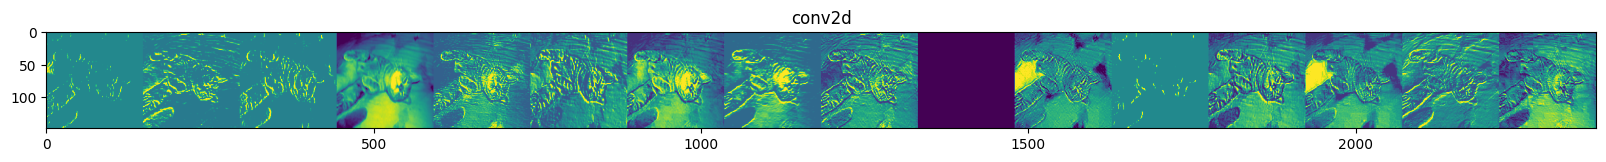

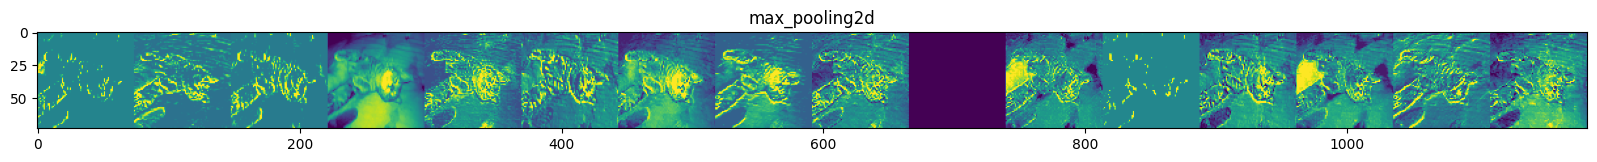

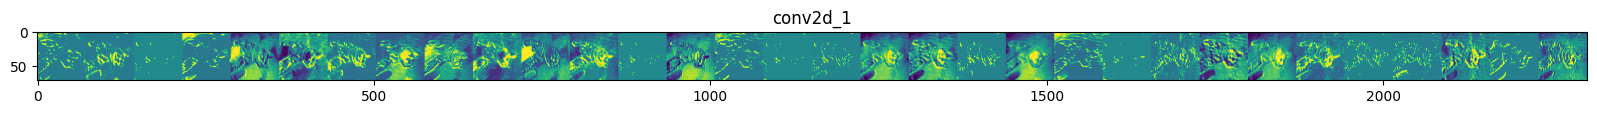

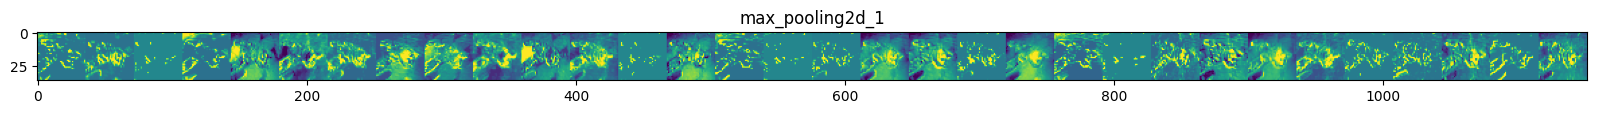

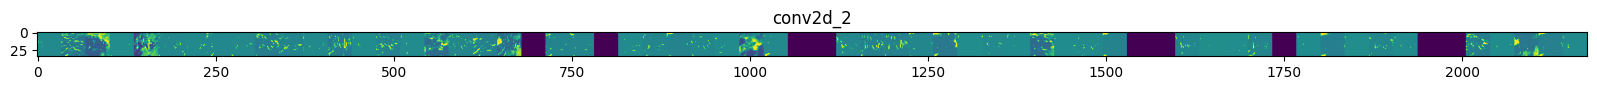

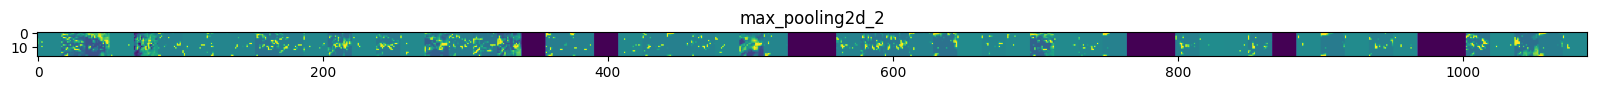

In [ ]:
# Vamos definir um novo modelo que receberá as imagens como entrada, e na saída
# representações intermediárias para todas as camadas no modelo anterior após
# o primeiro.
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = Model(img_input, successive_outputs)

# Selecionando aleatoriamente uma imagem de entrada de um cão e de um gato
# do conjunto de treinamento.
cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]
img_path = random.choice(cat_img_files + dog_img_files)

img = load_img(img_path, target_size=(150, 150))  # imagem PIL
x = img_to_array(img)  # Numpy array de (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array de (1, 150, 150, 3)

# Reescalar por 1/255
x /= 255

# Executando a imagem através da rede, obtendo todas as representações
# intermediárias para essa imagem
successive_feature_maps = visualization_model.predict(x)

# Estes são os nomes das camadas, as quais ppodem fazer parte do plot
layer_names = [layer.name for layer in model.layers[1:]]

# Agora, vamos mostrar as representações
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Fazer isso apenas para as camadas convolucionais e maxpoool, mas não
    # para as camadas completamente conectadas
    n_features = feature_map.shape[-1]  # número de features no feature map
    # O feature map é (1, size, size, n_features)
    size = feature_map.shape[1]
    # Colocaremos as imagens nesta matriz
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # Colocaremos cada filtro no grid horizontal
      display_grid[:, i * size : (i + 1) * size] = x
    # Mostrar o grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

Como você pode ver, passamos dos pixels brutos das imagens para representações cada vez mais abstratas e compactas. As representações *downstream* começam a destacar o que a rede presta atenção e mostram cada vez menos *features* sendo "ativadas"; a maioria é definida como zero. Isso é chamado de "esparsidade". Essa representação é o ponto chave do aprendizado profundo.

Essas representações carregam cada vez menos informações sobre os pixels originais da imagem, porém informações cada vez mais refinadas sobre a classe da imagem. Você pode pensar em uma *convnet* (ou uma rede profunda em geral) como um *pipeline* de extração de informações.

# Avaliando os resultados

Vamos "plotar" os valores de acurácia e taxa de perda (loss) de treino e validação, as quais foram coletadas durante o treinamento:

Text(0.5, 1.0, 'Training and validation loss')

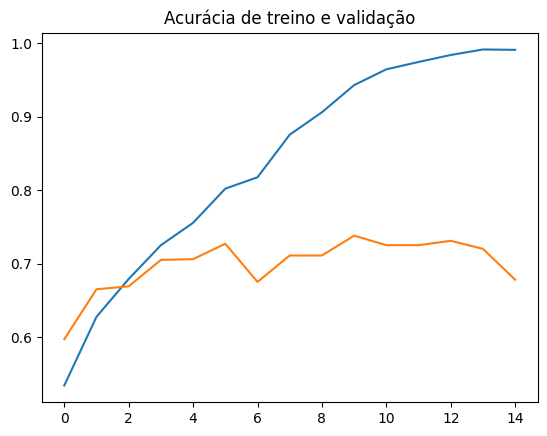

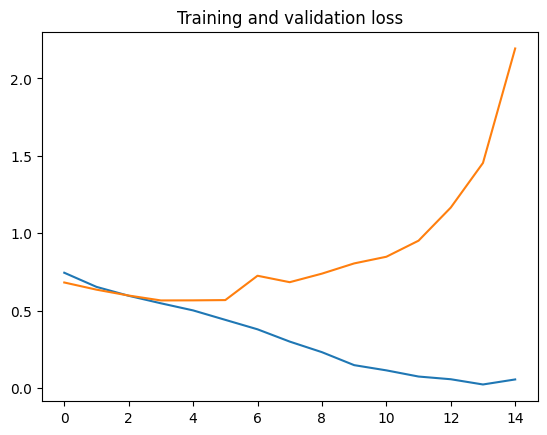

In [ ]:
# Recuperar uma lista de resultados de acurácia nos cojuntos de dados de
# treinamento e validação para cada época do treinamento
acc = history.history['acc']
val_acc = history.history['val_acc']

# Recuperar uma lista de resultados de perda (loss) nos conjuntos de dados de 
# treinamento e validação para cada época do treinamento
loss = history.history['loss']
val_loss = history.history['val_loss']

# Pegar o número de épocas
epochs = range(len(acc))

# "Plotar" a acurácia de treino e validação em cada época
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Acurácia de treino e validação')

plt.figure()

# "Plotar" a perda (loss) de treino e validação em cada época
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Taxa de Perda de treino e validação')


É possível notar que a acurácia/perda para o conjunto de validação (laranja) para de aumentar/diminuir a partir de 5a época, aproximadamente. Isso é um indício de um super-ajuste (overfitting) do modelo, uma vez que a acurácia/perda segue aumentando/diminuindo até bem próximo de 100%/0. 

O *overfitting* ocorre quando um modelo se super-ajusta aos exemplos (neste caso, poucos) de treino, tornando-os incapazes de generalizar. Como temos um número relativamente pequeno de exemplos de treinamento (2000), o modelo pode pode começar a utilizar *features* irrelevantes para fazer previsões. Por exemplo, se você, como humano, vê apenas três imagens de pessoas que são lenhadores e três imagens de pessoas que são marinheiros, e dentre elas a única pessoa usando boné é um lenhador, você pode começar a pensar que somente lenhador usa boné. Você seria então um péssimo classificador de lenhador/marinheiro, apesar de ter acertado 100% dos casos no treinamento.

#Agradecimento:

Aula prática baseada no material disponibilizado em:

https://colab.research.google.com/github/google/eng-edu/blob/master/ml/pc/exercises/image_classification_part1.ipynb#scrollTo=Wpr8GxjOU8in
